# Skeleton Threat Detection

In [1]:
import time
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

# Part 1: Load Data

In [2]:
# set relevant skeletal indexes in the desired order with labels. Create array for skeletons with confidence flag
rele_dexes = [2,3,4,9,5,6,7,12,1,-1]
joint_names = ['R Shoulder','R Elbow','R Wrist','R Hip','L Shoulder','L Elbow','L Wrist','L Hip','Chest','Gun']
conf_flag = 1   # should be 0 or 1
x = np.empty((1,len(rele_dexes),2+conf_flag))
y = []

# set indexes for normalization 
right_elbow = 3
right_wrist = 4

#set folders and labels for each folder (0=high,1=medium,2=low)
folders = ["body_25/high/skeletons/", "body_25/medium/skeletons/", "body_25/mild/skeletons/", "body_25/low/skeletons/"]
threats = [0,1,2,2]

#read skeletons into array and create labels
last_count = 0
for folder in range(len(folders)):
    for f in listdir(folders[folder]):
        skele = np.load(folders[folder]+f)    #read skeletons
        skele[-1][-1] = 1  #reset gun confidence which is always 0 in given files
        if skele[rele_dexes].all() > .0001:     #only include skeletons with all joints
            skele[:,0:2] -= skele[right_elbow,0:2]     #normalize to right elbow with elbow to wrist=1
            forearm_len = np.sqrt(skele[right_wrist][0]**2+skele[right_wrist][1]**2)
            skele[:,0:2] /= forearm_len
            x = np.vstack((x,np.expand_dims(skele[rele_dexes,0:2+conf_flag],axis=0))) #add to input array
    y = np.concatenate((y,[threats[folder]]*(x.shape[0]-last_count)))   #add labels to label list
    last_count = x.shape[0]
                    
x_flat = x.reshape([x.shape[0],x.shape[1]*x.shape[2]]) #flatten for neural network input

#checks for sizes
print(x.shape)
print(y.shape)
print(x[-1])

(1279, 10, 3)
(1279,)
[[-0.19211676 -1.03471354  0.64964402]
 [ 0.          0.          0.81176996]
 [ 0.4143182   0.91013209  0.77478099]
 [-0.96485562  0.5379595   0.39770767]
 [ 0.35900436 -1.04828018  0.62941569]
 [ 0.37315739 -0.27657718  0.56949055]
 [ 1.00827449 -0.48247441  0.80475724]
 [-0.44058157  0.55179644  0.34119952]
 [ 0.09696757 -1.0350196   0.71582872]
 [-0.95738372  0.75766429  1.        ]]


In [3]:
# create one hot label array from labels
oh_y = np.array(y,dtype=np.int64)
num_labels = len(np.unique(oh_y))
oh_y = np.eye(num_labels)[oh_y]

# columns: x, y, confidence

# Create and Train Model

In [4]:
from feedforward_model import *

In [5]:
# set splits for k-folds and create empty array
splits = 10
kf = KFold(n_splits=splits, shuffle=True, random_state=1)
conf_mat = np.empty((splits,num_labels,num_labels))

# train models for each split and save to an array
i = 0
for train_index, test_index in kf.split(x_flat):
    x_train, x_test = x_flat[train_index], x_flat[test_index]   #create train and test sets
    y_train, y_test = oh_y[train_index], oh_y[test_index]
    
    # create and train model
    model = feedforward(x_flat.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
    model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64)
    conf_mat[i] = confusion_matrix(y[test_index],model.predict(x_test)[0])  #add confusion matrix to array
    i += 1

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

number of batches for training: 17
0.07800173759460449
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.5%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.21875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 58.59375%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 66.40625%
epoch 9
Best validation accuracy! iteration:150 accuracy: 75.78125%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 78.125%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 78.90625%
epoch 15
epoch 16
epoch 17
epoch 1

epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 70.3125%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 71.09375%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 71.09375. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 17
0.01686239242553711
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.75%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 65.625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 66.40625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 70.3125%
epoch 9
Best validation accuracy! iteration:150 accuracy: 71.875%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 73.43

[[403.  22.  15.]
 [ 66.  81. 124.]
 [ 49.  15. 504.]]
mean
[[40.3  2.2  1.5]
 [ 6.6  8.1 12.4]
 [ 4.9  1.5 50.4]]
std
[[5.62227712 2.44131112 1.11803399]
 [4.29418211 4.9689033  2.45764115]
 [1.97230829 1.36014705 3.13687743]]
77.24784988272087
0.635860066031195
8.132650244538985


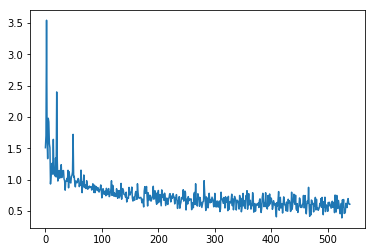

In [6]:
# plot loss, total classifications, mean over splits, and std over splits
model.plot()
print(sum(conf_mat))
print("mean")
print(np.mean(conf_mat,axis=0))
print("std")
print(np.std(conf_mat,axis=0))

#create accuracy (sum of diagonal dividied by total classified)
mat = sum(conf_mat)
diag = sum(np.diagonal(mat))
print(diag/sum(sum(mat))*100)

#find and print standard deviations
stds = np.std(conf_mat,axis=0)
var = 0
for i in range(conf_mat.shape[1]):
    var += stds[i,i]**2
print(np.sqrt(var)/sum(sum(mat))*100)
print(np.sqrt(var))

In [7]:
#give a prediction example
labels = np.array(['High','Med','Low'])
test = np.reshape(x_test[0],(1,len(x_test[0])))
prediction = model.predict(test)
print("Predicted label is ", labels[prediction[0][0]])
tested_y = np.ndarray.astype(y_test[0],bool)
print("Actual label is ",labels[tested_y][0])

INFO:tensorflow:Restoring parameters from model/basic_model
Predicted label is  High
Actual label is  High


In [8]:
# find and print mean and totals in LaTeX code
mean = np.mean(conf_mat,axis=0)
totals_b = np.sum(mean,axis=0)
totals_r = np.sum(mean,axis=1)
total = np.sum(totals_r)
print(end='\\rota{Actual}')
for i in range(mean.shape[0]):
    print(" & {0:s} & {1:.1f} & {2:.1f} & {3:.1f} & {4:.1f} \\\\".format(labels[i],mean[i,0],mean[i,1],mean[i,2],totals_r[i]))
print('\\toprule')
print(" & Totals & {0:.1f} & {1:.1f} & {2:.1f} & {3:.1f}".format(totals_b[0],totals_b[1],totals_b[2],total))

\rota{Actual} & High & 40.3 & 2.2 & 1.5 & 44.0 \\
 & Med & 6.6 & 8.1 & 12.4 & 27.1 \\
 & Low & 4.9 & 1.5 & 50.4 & 56.8 \\
\toprule
 & Totals & 51.8 & 11.8 & 64.3 & 127.9


In [9]:
#create new confusion matrix
conf_mat = np.empty((x.shape[1],splits,num_labels,num_labels))

#remove each joint from input and retrain with k-folds
for i in range(x.shape[1]):
    print(i)
    sub_x = np.delete(x,i,1)
    sub_x = sub_x.reshape([sub_x.shape[0],sub_x.shape[1]*sub_x.shape[2]])
    j = 0
    for train_index, test_index in kf.split(sub_x):
        x_train, x_test = sub_x[train_index], sub_x[test_index]
        y_train, y_test = oh_y[train_index], oh_y[test_index]
        model = feedforward(sub_x.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
        model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64)
        conf_mat[i,j] = confusion_matrix(y[test_index],model.predict(x_test)[0])
        j += 1

0
number of batches for training: 17
0.0288846492767334
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.0%
epoch 3
Best validation accuracy! iteration:50 accuracy: 67.96875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 70.3125%
epoch 6
Best validation accuracy! iteration:100 accuracy: 73.4375%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 77.34375%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 78.90625%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 79.6875%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:400 accuracy: 81.25%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.25. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 17
0.019010066986083984
epoch 1
epoch 2
Best valida

number of batches for training: 17
0.02240157127380371
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.21875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 62.5%
epoch 6
Best validation accuracy! iteration:100 accuracy: 65.625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 71.875%
epoch 9
Best validation accuracy! iteration:150 accuracy: 73.4375%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 76.5625%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 77.34375%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 78.125%
epoch 18
Best validation accuracy! iteration:300 accuracy: 79.6875%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.6875. Model named basic_model.
INFO:tensorflow:Restoring p

epoch 12
Best validation accuracy! iteration:200 accuracy: 73.4375%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 74.21875%
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 75.0%
epoch 24
Best validation accuracy! iteration:400 accuracy: 75.78125%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.78125. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 17
0.01656174659729004
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 57.03125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.71875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 68.75%
epoch 6
Best validation accuracy! iteration:100 accuracy: 69.53125%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 70.3125%
epoch 9
Best validation accuracy! iteration:15

epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.5625. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 17
0.0197451114654541
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.90625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 67.1875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 70.3125%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 71.09375%
epoch 9
Best validation accuracy! iteration:150 accuracy: 71.875%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 72.65625%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 73.4375%
epoch 21
Best val

Best validation accuracy! iteration:200 accuracy: 71.875%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 72.65625%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 73.4375%
epoch 24
Best validation accuracy! iteration:400 accuracy: 74.21875%
epoch 25
Best validation accuracy! iteration:425 accuracy: 75.0%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.0. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 17
0.01818537712097168
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.3125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 67.96875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 72.65625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 74.21875%
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best 

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:500 accuracy: 82.03125%
Traning ends. The best valid accuracy is 82.03125. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 17
0.016882658004760742
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.15625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.03125%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 65.625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 72.65625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 75.0%
epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 77.34375%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.34375. Model named basic_mode

epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:475 accuracy: 74.80314960629921%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:525 accuracy: 75.59055118110236%
Traning ends. The best valid accuracy is 75.59055118110236. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
5
number of batches for training: 17
0.02493596076965332
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 25.0%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.78125%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 60.15625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 67.96875%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 72.65625%
epoch 9
Best validation accuracy! iteration:150 accuracy: 74.21875%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 75.78125%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 77.34375%
epoch 15
epoch 1

number of batches for training: 17
0.016609668731689453
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.75%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.65625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 60.9375%
epoch 6
Best validation accuracy! iteration:100 accuracy: 67.1875%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 69.53125%
epoch 9
Best validation accuracy! iteration:150 accuracy: 71.875%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 73.4375%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 75.78125%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 77.34375%
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 78.90625%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:500 accuracy: 79.6875%
Traning ends. The best valid accura

epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 77.34375%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 78.125%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.125. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 17
0.016824960708618164
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.21875%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.15625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 64.84375%
epoch 6
Best validation accuracy! iteration:100 accuracy: 67.96875%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 69.53125%
epoch 9
Best validation accuracy! iteration:150 accuracy: 71.09375%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 72.65625%
epoch 13
epoch

INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 17
0.016597986221313477
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.125%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 61.71875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 71.09375%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 73.4375%
epoch 9
Best validation accuracy! iteration:150 accuracy: 76.5625%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 77.34375%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.34375. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 17
0.017652273178100586
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.71875%
ep

epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 75.0%
epoch 12
Best validation accuracy! iteration:200 accuracy: 78.125%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.125. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 17
0.016458988189697266
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.65625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.5%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 64.0625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 69.53125%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 72.65625%
epoch 9
Best validation accuracy! iteration:150 accuracy: 76.5625%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 78.90625%
epoch 

epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 71.09375%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:400 accuracy: 71.875%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 71.875. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 17
0.016712427139282227
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.34375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.71875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 68.75%
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 69.53125%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 70.3125%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validat

In [10]:
# print sums, means, and stds
for i in range(conf_mat.shape[0]):
    print(joint_names[i])
    print(sum(conf_mat[i]))
print("mean")
print(np.mean(conf_mat,axis=0))
print("std")
print(np.std(conf_mat,axis=0))

R Shoulder
[[393.  24.  23.]
 [ 61.  88. 122.]
 [ 43.  13. 512.]]
R Elbow
[[390.  27.  23.]
 [ 46.  94. 131.]
 [ 48.  14. 506.]]
R Wrist
[[391.  31.  18.]
 [ 52.  79. 140.]
 [ 41.  19. 508.]]
R Hip
[[396.  26.  18.]
 [ 51. 101. 119.]
 [ 45.  18. 505.]]
L Shoulder
[[388.  31.  21.]
 [ 56.  87. 128.]
 [ 42.  15. 511.]]
L Elbow
[[395.  23.  22.]
 [ 57.  81. 133.]
 [ 44.  17. 507.]]
L Wrist
[[391.  30.  19.]
 [ 54.  95. 122.]
 [ 50.  10. 508.]]
L Hip
[[389.  34.  17.]
 [ 60.  88. 123.]
 [ 45.  14. 509.]]
Chest
[[400.  25.  15.]
 [ 46. 106. 119.]
 [ 44.  20. 504.]]
Gun
[[379.  20.  41.]
 [ 52.  68. 151.]
 [ 66.  19. 483.]]
mean
[[[41.   2.4  1.6]
  [ 4.5  7.7 12.8]
  [ 1.8  2.6 53.6]]

 [[40.2  4.8  4. ]
  [ 6.   9.3 10.7]
  [ 3.9  2.2 46.9]]

 [[34.   4.   2. ]
  [ 4.4 10.1 14.5]
  [ 5.4  0.9 52.7]]

 [[41.   1.9  3.1]
  [ 7.7  7.3 10. ]
  [ 5.2  2.3 49.5]]

 [[38.4  2.4  2.2]
  [ 4.5  6.  16.5]
  [ 3.4  2.2 52.4]]

 [[48.2  3.4  3.4]
  [ 5.3  5.   8.7]
  [ 7.2  1.3 45.5]]

 [[41.2  2.4  2

In [11]:
# set variables for mean, variance, and sum values
m = 0
v = 0
s = 0

#for each joint, calculate accuracy %, mean, and std
for i in range(conf_mat.shape[0]):
    print(joint_names[i])
    mat = sum(conf_mat[i])
    diag = sum(np.diagonal(mat))
    print(diag/sum(sum(mat))*100)
    m += diag/sum(sum(mat))*100
    stds = np.std(conf_mat[i],axis=0)
    var = 0
    for j in range(stds.shape[1]):
        var += stds[j,j]**2
    v += var
    s += sum(sum(mat))
    
print(1)
print(m/(conf_mat.shape[0]-1))
print(np.sqrt(v)/s*100)

R Shoulder
77.63878029710712
R Elbow
77.40422204847536
R Wrist
76.4659890539484
R Hip
78.34245504300235
L Shoulder
77.09147771696638
L Elbow
76.85691946833464
L Wrist
77.71696637998437
L Hip
77.09147771696638
Chest
78.96794370602032
Gun
72.71305707584051
1
85.58769872296065
0.1575250697039941


In [12]:
# create empty confusion matrix
conf_mat = np.empty((x.shape[1],x.shape[1],splits,num_labels,num_labels))

#remove two joints and retrain network with k-folds
for i in range(x.shape[1]):
    for j in range(i,x.shape[1]):
        sub_x = np.delete(x,[i,j],1)
        sub_x = sub_x.reshape([sub_x.shape[0],sub_x.shape[1]*sub_x.shape[2]])
        k = 0
        for train_index, test_index in kf.split(sub_x):
            x_train, x_test = sub_x[train_index], sub_x[test_index]
            y_train, y_test = oh_y[train_index], oh_y[test_index]
            model = feedforward(sub_x.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
            model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64,model_name="model")
            conf_mat[i,j,k] = confusion_matrix(y[test_index],model.predict(x_test)[0])
            k+= 1

number of batches for training: 17
0.017304658889770508
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.34375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 64.0625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 73.4375%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 75.0%
epoch 9
Best validation accuracy! iteration:150 accuracy: 75.78125%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 78.125%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 79.6875%
epoch 15
Best validation accuracy! iteration:250 accuracy: 80.46875%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:400 accuracy: 81.25%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.25. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.

epoch 12
Best validation accuracy! iteration:200 accuracy: 79.6875%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 81.25%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.25. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 18
0.01648998260498047
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 23.62204724409449%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.881889763779526%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 56.69291338582677%
epoch 6
Best validation accuracy! iteration:100 accuracy: 61.417322834645674%
epoch 7
Best validation accuracy! iteration:125 accuracy: 67.71653543307087%
epoch 8
epoch 9
Best validation accuracy! iteration:150 accuracy: 72.44094488188976%
epoch 10
Best validation accuracy! iteration:175 acc

number of batches for training: 17
0.018407106399536133
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.03125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.34375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 60.9375%
epoch 6
Best validation accuracy! iteration:100 accuracy: 65.625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 69.53125%
epoch 9
Best validation accuracy! iteration:150 accuracy: 71.875%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 72.65625%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 76.5625%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:475 accuracy: 77.34375%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.34375. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for traini

number of batches for training: 17
0.017533540725708008
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.71875%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.25%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 68.75%
epoch 6
Best validation accuracy! iteration:100 accuracy: 71.875%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 72.65625%
epoch 9
Best validation accuracy! iteration:150 accuracy: 73.4375%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 74.21875%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 75.0%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 75.78125%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.78125. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17


number of batches for training: 17
0.01676154136657715
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.4375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.21875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 53.125%
epoch 6
Best validation accuracy! iteration:100 accuracy: 55.46875%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 60.15625%
epoch 9
Best validation accuracy! iteration:150 accuracy: 68.75%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 71.875%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 73.4375%
epoch 15
Best validation accuracy! iteration:250 accuracy: 74.21875%
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 75.78125%
epoch 18
Best validation accuracy! iteration:300 accuracy: 78.125%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 79.6875%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 

epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 78.125%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 78.90625%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:400 accuracy: 79.6875%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:475 accuracy: 83.59375%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.59375. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016896963119506836
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.875%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.25%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 64.84375%
epoch 6
Best validation accuracy! iteration:100 accuracy: 66.40625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 68.75%
epoch 9
Best validation accuracy! iteration:150 accuracy: 6

epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 67.96875%
epoch 15
Best validation accuracy! iteration:250 accuracy: 71.875%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 72.65625%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:400 accuracy: 75.0%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:500 accuracy: 75.78125%
Traning ends. The best valid accuracy is 75.78125. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 18
0.016893863677978516
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.84251968503938%
epoch 3
Best validation accuracy! iteration:50 accuracy: 73.22834645669292%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 74.80314960629921%
epoch 6
Best validation accuracy! iteration:100 accuracy: 77.16535433070865%
epoch 7
Best validation accuracy! iteration

number of batches for training: 17
0.01767110824584961
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.90625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.15625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 65.625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 69.53125%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 71.09375%
epoch 9
Best validation accuracy! iteration:150 accuracy: 72.65625%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 73.4375%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:400 accuracy: 74.21875%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:475 accuracy: 75.0%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.0. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17

number of batches for training: 17
0.016945600509643555
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.96875%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.15625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 64.0625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 71.09375%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 72.65625%
epoch 9
Best validation accuracy! iteration:150 accuracy: 75.0%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 75.78125%
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:425 accuracy: 76.5625%
epoch 26
epoch 27
Best validation accuracy! iteration:450 accuracy: 77.34375%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.34375. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for traini

number of batches for training: 17
0.01692366600036621
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 60.9375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 67.1875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 72.65625%
epoch 6
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:150 accuracy: 73.4375%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 74.21875%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 77.34375%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.34375. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.01666092872619629
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.84375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 40.625%
epoch 4
epo

epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.6875. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.02126932144165039
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 58.59375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 68.75%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 72.65625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 73.4375%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 75.78125%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 76.5625%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 77.34375%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 78.125%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.125. Model named model.
INFO:

epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.52755905511812. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.017227649688720703
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.8125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 53.125%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 58.59375%
epoch 6
Best validation accuracy! iteration:100 accuracy: 64.0625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 67.1875%
epoch 9
Best validation accuracy! iteration:150 accuracy: 70.3125%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 72.65625%
epoch 12
Best validation accuracy! iteration:200 accuracy: 73.4375%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 74.21875%
epoch 15
Best validation accuracy! iteration:250 accuracy: 75.0%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accur

number of batches for training: 18
0.016808271408081055
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.96850393700787%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.629921259842526%
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:100 accuracy: 61.417322834645674%
epoch 7
Best validation accuracy! iteration:125 accuracy: 64.56692913385827%
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:175 accuracy: 66.14173228346458%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:250 accuracy: 68.50393700787401%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:375 accuracy: 69.29133858267717%
epoch 22
epoch 23
Best validation accuracy! iteration:400 accuracy: 70.07874015748031%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 70.07874015748031. Model named model.
INFO:tensorflow:Restoring parameters from model/mode

number of batches for training: 17
0.016948938369750977
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.40625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.46875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 68.75%
epoch 6
Best validation accuracy! iteration:100 accuracy: 70.3125%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 71.875%
epoch 9
Best validation accuracy! iteration:150 accuracy: 73.4375%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 75.0%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 75.78125%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:400 accuracy: 76.5625%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:475 accuracy: 78.125%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.125. Model named model.
INFO:tensorflow:Restoring parame

epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 79.6875%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.6875. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016532421112060547
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.09375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.5625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 67.1875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 72.65625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 75.0%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 75.78125%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 

epoch 12
Best validation accuracy! iteration:200 accuracy: 75.0%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 75.78125%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.78125. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016902446746826172
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.9375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 68.75%
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 70.3125%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 71.09375%
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 71.875%
epoch 21
Best 

epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.6875. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.017770767211914062
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.15625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 67.1875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 71.875%
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:150 accuracy: 72.65625%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 73.4375%
epoch 15
Best validation accuracy! iteration:250 accuracy: 74.21875%
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 75.78125%
epoch 18
Best validation accuracy! iteration:300 accuracy: 76.5625%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:400 accuracy: 77.3437

number of batches for training: 17
0.016590118408203125
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.8125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 35.15625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 49.21875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 64.84375%
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:150 accuracy: 68.75%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 70.3125%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 71.09375%
epoch 15
Best validation accuracy! iteration:250 accuracy: 71.875%
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 72.65625%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 74.21875%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 75.0%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy

number of batches for training: 17
0.017608642578125
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.25%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.25%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 58.59375%
epoch 6
Best validation accuracy! iteration:100 accuracy: 61.71875%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 67.1875%
epoch 9
Best validation accuracy! iteration:150 accuracy: 72.65625%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 74.21875%
epoch 12
Best validation accuracy! iteration:200 accuracy: 76.5625%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 77.34375%
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 81.25%
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 82.03125%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is

epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 76.5625%
epoch 15
Best validation accuracy! iteration:250 accuracy: 77.34375%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 78.125%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:450 accuracy: 78.90625%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:500 accuracy: 79.6875%
Traning ends. The best valid accuracy is 79.6875. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 18
0.016976356506347656
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.96850393700787%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.417322834645674%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 64.56692913385827%
epoch 6
Best validation accuracy! iteration:100 accuracy: 70.86614173228347%
epoch 7
Best validation accuracy! iterati

epoch 12
Best validation accuracy! iteration:200 accuracy: 69.53125%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 70.3125%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 71.875%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 72.65625%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 73.4375%
epoch 24
Best validation accuracy! iteration:400 accuracy: 74.21875%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.21875. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.017194032669067383
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.71875%
epoch 3
Best validation accuracy! iteration:50 accuracy: 43.75%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 55.46875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 66.40625%
epoch 7
epo

number of batches for training: 17
0.01900029182434082
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 25.78125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 32.8125%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 47.65625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 59.375%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 74.21875%
epoch 9
Best validation accuracy! iteration:150 accuracy: 75.0%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 75.78125%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 76.5625%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:500 accuracy: 77.34375%
Traning ends. The best valid accuracy is 77.34375. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training:

epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:450 accuracy: 72.65625%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 72.65625. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.01651597023010254
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.40625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 53.125%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 58.59375%
epoch 6
Best validation accuracy! iteration:100 accuracy: 66.40625%
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:150 accuracy: 68.75%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 71.09375%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 71.875%


number of batches for training: 17
0.016530513763427734
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 38.28125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 54.6875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 66.40625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 70.3125%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 71.09375%
epoch 9
Best validation accuracy! iteration:150 accuracy: 72.65625%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 73.4375%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 74.21875%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.21875. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.01674509048461914
epoch 1
epoch 2
Best validatio

epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 76.5625%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.5625. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016613483428955078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 28.90625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 40.625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 49.21875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 52.34375%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 53.90625%
epoch 9
Best validation accuracy! iteration:150 accuracy: 55.46875%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 61.71875%
epoch 12
Best validation accuracy! iteration:200 accuracy: 64.0625%
epoch 13
epoch 14


number of batches for training: 18
0.019708633422851562
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 28.346456692913385%
epoch 3
Best validation accuracy! iteration:50 accuracy: 37.00787401574803%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 54.330708661417326%
epoch 6
Best validation accuracy! iteration:100 accuracy: 62.99212598425197%
epoch 7
Best validation accuracy! iteration:125 accuracy: 69.29133858267717%
epoch 8
epoch 9
Best validation accuracy! iteration:150 accuracy: 77.16535433070865%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:475 accuracy: 78.74015748031496%
epoch 28
Best validation accuracy! iteration:500 accuracy: 80.31496062992126%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.31496062992126. Model named model.
INFO:tensorflow:Restoring parameters from model/model

INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016665935516357422
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.15625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 61.71875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 65.625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 66.40625%
epoch 9
Best validation accuracy! iteration:150 accuracy: 70.3125%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 71.875%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 73.4375%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 75.78125%
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:400 accuracy: 76.5625%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:450 accuracy: 77.34375%
epoch 28

number of batches for training: 17
0.01648688316345215
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 60.9375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 67.1875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 71.09375%
epoch 6
Best validation accuracy! iteration:100 accuracy: 72.65625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 74.21875%
epoch 9
Best validation accuracy! iteration:150 accuracy: 75.78125%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 76.5625%
epoch 12
Best validation accuracy! iteration:200 accuracy: 77.34375%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 78.125%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.125. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training

Best validation accuracy! iteration:250 accuracy: 76.5625%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:500 accuracy: 77.34375%
Traning ends. The best valid accuracy is 77.34375. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.01668405532836914
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.9375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.25%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 61.71875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 71.09375%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 72.65625%
epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 73.4375%
epoch 12
Best validation accuracy! iteration:200 accuracy: 74.21875%
epoch 13
epoch 14
Best validation accuracy! iteration:22

number of batches for training: 17
0.016429901123046875
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 28.90625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 35.15625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 47.65625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 55.46875%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 56.25%
epoch 9
Best validation accuracy! iteration:150 accuracy: 59.375%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 62.5%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 63.28125%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 64.84375%
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 67.1875%
epoch 21
Best validation accuracy! iteration:350 accuracy: 69.53125%
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 71.875%
epoch 24
Best validation accuracy! iterat

epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 73.4375%
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 74.21875%
epoch 18
Best validation accuracy! iteration:300 accuracy: 75.0%
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 75.78125%
epoch 21
Best validation accuracy! iteration:350 accuracy: 76.5625%
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 78.125%
epoch 24
epoch 25
Best validation accuracy! iteration:425 accuracy: 78.90625%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.90625. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.01667332649230957
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.5625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.03125%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 71.09375%
epoch 6
epoch 7
epoch 8
Best va

epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 75.0%
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 76.5625%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.5625. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 18
0.01656341552734375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.09448818897638%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.45669291338583%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 51.96850393700787%
epoch 6
Best validation accuracy! iteration:100 accuracy: 53.54330708661418%
epoch 7
Best validation accuracy! iteration:125 accuracy: 55.118110236220474%
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:175 accuracy: 57.48031496062992%
epoch 11
epoch 12
Best validation accuracy! iteration:200 acc

number of batches for training: 17
0.017099857330322266
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.09375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.4375%
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:100 accuracy: 56.25%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 63.28125%
epoch 9
Best validation accuracy! iteration:150 accuracy: 66.40625%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 67.96875%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 70.3125%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 71.09375%
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:450 accuracy: 71.875%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 71.875. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training

number of batches for training: 17
0.01688671112060547
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.53125%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 50.78125%
epoch 6
Best validation accuracy! iteration:100 accuracy: 60.15625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 67.96875%
epoch 9
Best validation accuracy! iteration:150 accuracy: 70.3125%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 72.65625%
epoch 12
Best validation accuracy! iteration:200 accuracy: 73.4375%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 75.0%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 75.78125%
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 76.5625%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 78.125%
epoch 24
epoch 25
epoch 26
epoch 27
epoch

number of batches for training: 17
0.01659703254699707
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.65625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.25%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 61.71875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 65.625%
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:150 accuracy: 67.96875%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 69.53125%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 70.3125%
epoch 15
Best validation accuracy! iteration:250 accuracy: 72.65625%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:400 accuracy: 73.4375%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:475 accuracy: 74.21875%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.21875. Model named model.
INFO:tensorflow:Restorin

epoch 15
Best validation accuracy! iteration:250 accuracy: 78.125%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 78.90625%
epoch 21
Best validation accuracy! iteration:350 accuracy: 79.6875%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:450 accuracy: 82.03125%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03125. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016665220260620117
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.84375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.21875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 54.6875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 59.375%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 60.9375%
epoch 9
Best validation accuracy! iteration:150 accuracy: 66.40625%
epoch 10
epoch

epoch 30
Traning ends. The best valid accuracy is 77.34375. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 18
0.01670241355895996
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 38.582677165354326%
epoch 3
Best validation accuracy! iteration:50 accuracy: 53.54330708661418%
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:100 accuracy: 60.629921259842526%
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:150 accuracy: 62.99212598425197%
epoch 10
Best validation accuracy! iteration:175 accuracy: 66.92913385826772%
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 69.29133858267717%
epoch 13
Best validation accuracy! iteration:225 accuracy: 70.07874015748031%
epoch 14
Best validation accuracy! iteration:250 accuracy: 74.01574803149606%
epoch 15
epoch 16
Best validation accuracy! iteration:275 accuracy: 74.80314960629921%
epoch 17
Best validation accuracy! iteration:300 accurac

epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.0. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016667604446411133
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.75%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.78125%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 55.46875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 59.375%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 60.9375%
epoch 9
Best validation accuracy! iteration:150 accuracy: 65.625%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 69.53125%
epoch 12
Best validation accuracy! iteration:200 accuracy: 71.875%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 75.0%
epoch 15
Best validati

epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 75.0%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:400 accuracy: 75.78125%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.78125. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.017001628875732422
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.15625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.4375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 64.0625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 67.96875%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 69.53125%
epoch 9
Best validation accuracy! iteration:150 accuracy: 71.875%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 72.65625%
epoch 13
epoch 14
Best validation accur

epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 75.78125%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:450 accuracy: 76.5625%
epoch 28
Best validation accuracy! iteration:475 accuracy: 77.34375%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.34375. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.019462108612060547
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.09375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.25%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 60.9375%
epoch 6
Best validation accuracy! iteration:100 accuracy: 64.0625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 64.84375%
epoch 9
Best validation accuracy! iteration:150 accuracy: 65.625%
epoch 10
epoch 11
Best validation accuracy! iter

epoch 12
Best validation accuracy! iteration:200 accuracy: 67.96875%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 71.09375%
epoch 15
Best validation accuracy! iteration:250 accuracy: 71.875%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 73.4375%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 73.4375. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.01702737808227539
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.6875%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.3125%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 50.0%
epoch 6
Best validation accuracy! iteration:100 accuracy: 59.375%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 64.0625%
epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:

number of batches for training: 17
0.01662302017211914
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.34375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.59375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 62.5%
epoch 6
Best validation accuracy! iteration:100 accuracy: 70.3125%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 75.0%
epoch 9
Best validation accuracy! iteration:150 accuracy: 78.125%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 78.90625%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 79.6875%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:450 accuracy: 81.25%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.25. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.0165

number of batches for training: 17
0.019866228103637695
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.53125%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 60.15625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 68.75%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 69.53125%
epoch 9
Best validation accuracy! iteration:150 accuracy: 72.65625%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 75.78125%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 76.5625%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 77.34375%
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 78.125%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:500 accuracy: 78.90625%
Traning ends. The best valid accur

number of batches for training: 17
0.01662135124206543
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 28.90625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 53.125%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 58.59375%
epoch 6
Best validation accuracy! iteration:100 accuracy: 68.75%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 70.3125%
epoch 9
Best validation accuracy! iteration:150 accuracy: 71.875%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 73.4375%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 73.4375. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016811609268188477
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.8125%
epoch 3
Best validation

epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 71.875%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 72.65625%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 73.4375%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 74.21875%
epoch 24
Best validation accuracy! iteration:400 accuracy: 75.0%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:450 accuracy: 75.78125%
epoch 28
Best validation accuracy! iteration:475 accuracy: 77.34375%
epoch 29
epoch 30
Best validation accuracy! iteration:500 accuracy: 78.125%
Traning ends. The best valid accuracy is 78.125. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.01829385757446289
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.96875%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.71875%
epoch 4
epoch 5
Best validation accuracy! iterat

number of batches for training: 17
0.0167539119720459
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.25%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.5%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 68.75%
epoch 6
Best validation accuracy! iteration:100 accuracy: 71.09375%
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 74.21875%
epoch 12
Best validation accuracy! iteration:200 accuracy: 75.0%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:500 accuracy: 75.78125%
Traning ends. The best valid accuracy is 75.78125. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.018573760986328125
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.78125%
epoch 3
Best validation acc

epoch 12
Best validation accuracy! iteration:200 accuracy: 71.875%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 73.4375%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 75.78125%
epoch 18
Best validation accuracy! iteration:300 accuracy: 77.34375%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 78.125%
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:425 accuracy: 78.90625%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:500 accuracy: 79.6875%
Traning ends. The best valid accuracy is 79.6875. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.022440195083618164
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.1875%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.25%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 67.1875%
epoch 6
Best validation 

epoch 13
epoch 14
Best validation accuracy! iteration:250 accuracy: 70.86614173228347%
epoch 15
epoch 16
Best validation accuracy! iteration:275 accuracy: 71.65354330708661%
epoch 17
Best validation accuracy! iteration:300 accuracy: 74.80314960629921%
epoch 18
epoch 19
Best validation accuracy! iteration:325 accuracy: 75.59055118110236%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:500 accuracy: 76.37795275590551%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.37795275590551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.01690530776977539
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 33.59375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 40.625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 50.0%
epoch 6
Best validation accuracy! iteration:100 accuracy: 64.0625%
epoch 7
epoch 8
Best valida

number of batches for training: 17
0.01665186882019043
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.8125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 42.1875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 43.75%
epoch 6
Best validation accuracy! iteration:100 accuracy: 55.46875%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 58.59375%
epoch 9
Best validation accuracy! iteration:150 accuracy: 62.5%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 63.28125%
epoch 12
Best validation accuracy! iteration:200 accuracy: 66.40625%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 67.1875%
epoch 15
Best validation accuracy! iteration:250 accuracy: 67.96875%
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 68.75%
epoch 18
Best validation accuracy! iteration:300 accuracy: 69.53125%
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 71.09375%
epoch 21
e

epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 76.5625%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 77.34375%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:450 accuracy: 78.90625%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.90625. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.01694321632385254
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 28.90625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.34375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 57.8125%
epoch 6
Best validation accuracy! iteration:100 accuracy: 60.9375%
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 62.5%
epoch 12
Best validation accuracy! iteration:200 accuracy: 67.1875%
epoch 13
epoch 14
Best validati

number of batches for training: 17
0.01771378517150879
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.25%
epoch 3
Best validation accuracy! iteration:50 accuracy: 68.75%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 71.875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 73.4375%
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:150 accuracy: 74.21875%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 75.0%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 75.78125%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.78125. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016901254653930664
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.75%
epoch 3
Best validation accu

number of batches for training: 17
0.0169219970703125
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 64.0625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 66.40625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 71.875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 74.21875%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 75.78125%
epoch 9
Best validation accuracy! iteration:150 accuracy: 76.5625%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 77.34375%
epoch 12
Best validation accuracy! iteration:200 accuracy: 78.125%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 79.6875%
epoch 21
Best validation accuracy! iteration:350 accuracy: 80.46875%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.46875. Model named model.
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016553163528442383
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 57.8125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 62.5%
epoch 6
Best validation accuracy! iteration:100 accuracy: 67.1875%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 68.75%
epoch 9
Best validation accuracy! iteration:150 accuracy: 71.09375%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 73.4375%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 74.21875%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:425 accuracy: 75.0%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.0. Model named model.
INFO:tensorflow:Restoring parameters from 

number of batches for training: 17
0.01677870750427246
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.3125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 54.6875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 66.40625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 67.96875%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 73.4375%
epoch 9
Best validation accuracy! iteration:150 accuracy: 75.0%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:200 accuracy: 75.78125%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 76.5625%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.5625. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.0186769962310791
epoch 1
epoch 2
Best validation accura

epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 68.75%
epoch 18
Best validation accuracy! iteration:300 accuracy: 69.53125%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 70.3125%
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:400 accuracy: 71.09375%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:500 accuracy: 72.65625%
Traning ends. The best valid accuracy is 72.65625. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 18
0.016892671585083008
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 24.409448818897637%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.031496062992126%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 55.90551181102362%
epoch 6
Best validation accuracy! iteration:100 accuracy: 58.26771653543307%
epoch 7
Best validation accuracy! iteration:125 accuracy: 62.20472

Best validation accuracy! iteration:200 accuracy: 69.53125%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 71.875%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 72.65625%
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 74.21875%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.21875. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.019467592239379883
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.03125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.59375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 67.96875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 71.09375%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 74.21875%
epoch 9
Best validation accuracy! iteration:150 accuracy: 7

number of batches for training: 17
0.016797304153442383
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 23.4375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 33.59375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 53.125%
epoch 6
Best validation accuracy! iteration:100 accuracy: 64.0625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 71.09375%
epoch 9
Best validation accuracy! iteration:150 accuracy: 71.875%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 74.21875%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 75.0%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:475 accuracy: 76.5625%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.5625. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17

number of batches for training: 17
0.016940832138061523
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.15625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.4375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 50.78125%
epoch 6
Best validation accuracy! iteration:100 accuracy: 53.90625%
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:150 accuracy: 57.8125%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 60.15625%
epoch 12
Best validation accuracy! iteration:200 accuracy: 71.09375%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 71.875%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 75.0%
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 75.78125%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:500 accuracy: 76.5625%
Traning ends. The best valid accura

number of batches for training: 17
0.0206148624420166
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.0%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.34375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 62.5%
epoch 6
Best validation accuracy! iteration:100 accuracy: 65.625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 68.75%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 71.09375%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 71.875%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:325 accuracy: 73.4375%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 74.21875%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.21875. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.017

epoch 13
Best validation accuracy! iteration:225 accuracy: 69.29133858267717%
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:475 accuracy: 70.07874015748031%
epoch 28
Best validation accuracy! iteration:500 accuracy: 70.86614173228347%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 70.86614173228347. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016690492630004883
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.34375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 64.84375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 72.65625%
epoch 6
Best validation accuracy! iteration:100 accuracy: 75.0%
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 75.78125%
epoch 16
epoch 17
epoch

epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:400 accuracy: 74.21875%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:450 accuracy: 75.0%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.0. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016630172729492188
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.8125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.4375%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 62.5%
epoch 6
Best validation accuracy! iteration:100 accuracy: 70.3125%
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 71.09375%
epoch 15
Best validation accuracy! iteration:250 accuracy: 71.875%
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 72.6

Traning ends. The best valid accuracy is 77.34375. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016692399978637695
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.3125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 54.6875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 61.71875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 67.1875%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 70.3125%
epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 71.09375%
epoch 12
Best validation accuracy! iteration:200 accuracy: 71.875%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 73.4375%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 74.21875%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid 

number of batches for training: 17
0.01656365394592285
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.59375%
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:100 accuracy: 63.28125%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 67.96875%
epoch 9
Best validation accuracy! iteration:150 accuracy: 70.3125%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 72.65625%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:275 accuracy: 73.4375%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 74.21875%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.21875. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.017806529998779297
epoch 1
epoch 2
Best validatio

number of batches for training: 17
0.016788721084594727
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.375%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.3125%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 49.21875%
epoch 6
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:150 accuracy: 50.78125%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 58.59375%
epoch 12
Best validation accuracy! iteration:200 accuracy: 66.40625%
epoch 13
epoch 14
Best validation accuracy! iteration:225 accuracy: 67.1875%
epoch 15
Best validation accuracy! iteration:250 accuracy: 71.875%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 72.65625%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 74.21875%
epoch 22
epoch 23
Best validation accuracy! iteration:375 accuracy: 75.0%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accurac

epoch 13
epoch 14
Best validation accuracy! iteration:250 accuracy: 77.95275590551181%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:325 accuracy: 78.74015748031496%
epoch 20
epoch 21
Best validation accuracy! iteration:375 accuracy: 79.52755905511812%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.52755905511812. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.016986370086669922
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.0625%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.15625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 71.875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 72.65625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 73.4375%
epoch 9
Best validation accuracy! iteration:150 accuracy: 74.21875%
epoch 10
epoch 11

number of batches for training: 17
0.016733407974243164
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.5%
epoch 3
Best validation accuracy! iteration:50 accuracy: 54.6875%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 59.375%
epoch 6
Best validation accuracy! iteration:100 accuracy: 64.0625%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 64.84375%
epoch 9
Best validation accuracy! iteration:150 accuracy: 66.40625%
epoch 10
epoch 11
Best validation accuracy! iteration:175 accuracy: 67.1875%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:250 accuracy: 69.53125%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 69.53125. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 18
0.016592979431152344
epoch 1
epoch 2
Best validation acc

number of batches for training: 17
0.017050981521606445
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 57.8125%
epoch 3
Best validation accuracy! iteration:50 accuracy: 64.0625%
epoch 4
epoch 5
Best validation accuracy! iteration:75 accuracy: 67.96875%
epoch 6
Best validation accuracy! iteration:100 accuracy: 68.75%
epoch 7
epoch 8
Best validation accuracy! iteration:125 accuracy: 71.09375%
epoch 9
Best validation accuracy! iteration:150 accuracy: 71.875%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:300 accuracy: 72.65625%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:350 accuracy: 73.4375%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 73.4375. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 17
0.018309593200683594
epoch 1
epoch 2
Best validation acc

In [13]:
#print accuracy for the removal of each joint pair
for i in range(conf_mat.shape[0]):
    for j in range(i,conf_mat.shape[1]):
        print(joint_names[i],joint_names[j])
        mat = sum(conf_mat[i,j])
        diag = sum(np.diagonal(mat))
        print(diag/sum(sum(mat))*100)

R Shoulder R Shoulder
78.49882720875684
R Shoulder R Elbow
76.85691946833464
R Shoulder R Wrist
76.77873338545739
R Shoulder R Hip
76.70054730258013
R Shoulder L Shoulder
78.1078967943706
R Shoulder L Elbow
77.16966379984362
R Shoulder L Wrist
76.77873338545739
R Shoulder L Hip
77.24784988272087
R Shoulder Chest
77.79515246286161
R Shoulder Gun
72.71305707584051
R Elbow R Elbow
77.40422204847536
R Elbow R Wrist
77.71696637998437
R Elbow R Hip
76.77873338545739
R Elbow L Shoulder
78.02971071149335
R Elbow L Elbow
77.32603596559812
R Elbow L Wrist
77.95152462861611
R Elbow L Hip
76.85691946833464
R Elbow Chest
77.71696637998437
R Elbow Gun
73.02580140734949
R Wrist R Wrist
77.56059421422987
R Wrist R Hip
77.16966379984362
R Wrist L Shoulder
77.24784988272087
R Wrist L Elbow
77.24784988272087
R Wrist L Wrist
77.63878029710712
R Wrist L Hip
76.6223612197029
R Wrist Chest
75.91868647380767
R Wrist Gun
70.28928850664582
R Hip R Hip
77.09147771696638
R Hip L Shoulder
78.34245504300235
R Hip L

In [14]:
#create matrix for percentages
percentages = np.zeros((conf_mat.shape[0],conf_mat.shape[0]))

#calculate percentages and print in LaTeX
for i in range(conf_mat.shape[0]):
    print(joint_names[i],end=' & ')
    for j in range(i):
        print("      & ", end='')
    for j in range(i,conf_mat.shape[1]-1):
        mat = sum(conf_mat[i,j])
        diag = sum(np.diagonal(mat))
        print(round(diag/sum(sum(mat))*100,1), end='\% & ')
        percentages[i,j] = percentages[j,i] = round(diag/sum(sum(mat))*100,1)
        if i == j:
            percentages[i,i] = 0
    mat = sum(conf_mat[i,-1])
    diag = sum(np.diagonal(mat))
    print(round(diag/sum(sum(mat))*100,1), "\% \\\\")
    percentages[i,-1] = percentages[-1,i] = round(diag/sum(sum(mat))*100,1)
    
#calculate averages without diagonals (only a single joint removed)
percentages[-1,-1] = 0
print("\\toprule")
print("Average \%",end=' & ')
for i in range(conf_mat.shape[0]-1):
    print(round(sum(percentages[i])/(conf_mat.shape[0]-1),1),end='\% & ')
print(round(sum(percentages[-1])/(conf_mat.shape[0]-1),1),end = '\%')
print('')
print(percentages)
print(conf_mat.shape[0])

R Shoulder & 78.5\% & 76.9\% & 76.8\% & 76.7\% & 78.1\% & 77.2\% & 76.8\% & 77.2\% & 77.8\% & 72.7 \% \\
R Elbow &       & 77.4\% & 77.7\% & 76.8\% & 78.0\% & 77.3\% & 78.0\% & 76.9\% & 77.7\% & 73.0 \% \\
R Wrist &       &       & 77.6\% & 77.2\% & 77.2\% & 77.2\% & 77.6\% & 76.6\% & 75.9\% & 70.3 \% \\
R Hip &       &       &       & 77.1\% & 78.3\% & 77.7\% & 77.1\% & 76.5\% & 76.2\% & 72.3 \% \\
L Shoulder &       &       &       &       & 77.6\% & 76.3\% & 77.4\% & 77.6\% & 77.2\% & 73.6 \% \\
L Elbow &       &       &       &       &       & 76.9\% & 76.3\% & 76.5\% & 76.7\% & 73.6 \% \\
L Wrist &       &       &       &       &       &       & 77.3\% & 77.8\% & 76.7\% & 72.6 \% \\
L Hip &       &       &       &       &       &       &       & 77.2\% & 78.0\% & 73.8 \% \\
Chest &       &       &       &       &       &       &       &       & 77.6\% & 73.0 \% \\
Gun &       &       &       &       &       &       &       &       &       & 74.0 \% \\
\toprule
Average \% & 76.7\% 